In [5]:
%%capture
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

In [6]:
import tensorflow as tf
from tensorflow import keras
import keras.utils

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.callbacks import ModelCheckpoint

import pandas as pd
import random
import numpy as np
from matplotlib import pyplot as plt

import fluidsynth
import pretty_midi
from IPython import display

from music21 import converter, instrument, note, chord, stream

In [7]:
print ("TF Version:", tf.__version__)
print ("Keras Version:", keras.__version__)

TF Version: 2.8.0
Keras Version: 2.8.0


In [8]:
from google.colab import drive
drive.mount("/content/gdrive/")

# location of data folder
ALLDATA_DIR = "/content/gdrive/MyDrive/Github/sm-caltech-stem-machine-learning/data/"

# location of MAESTRO data folder
DATA_DIR = "/content/gdrive/MyDrive/Github/sm-caltech-stem-machine-learning/data/maestro-v3.0.0/"

# location of weights folder
WEIGHTS_DIR = "/content/gdrive/MyDrive/Github/sm-caltech-stem-machine-learning/weights/"

Mounted at /content/gdrive/


In [9]:
metadata = pd.read_csv(DATA_DIR + "maestro-v3.0.0.csv");

metadata.head()

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471
2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433
3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588
4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508


In [10]:
# Shortening data for time sake

print(metadata.shape)
metadata = metadata[0:10]
print(metadata.shape)

(1276, 7)
(10, 7)


In [23]:
# Sampling rate for audio playback
_SAMPLING_RATE = 16000

def random_midi(df):
  rn = random.randint(0, df.shape[0])
  return DATA_DIR + metadata.iloc[rn]["midi_filename"]

def display_audio(midi_file):
  pm = pretty_midi.PrettyMIDI(midi_file) 
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  
  # Take a sample of the generated waveform to mitigate kernel resets
  return display.Audio(waveform, rate=_SAMPLING_RATE)
  
display_audio(random_midi(metadata))

Output hidden; open in https://colab.research.google.com to view.

In [16]:
notes = []
count = 0

for file in metadata["midi_filename"]:
  midi = converter.parse(DATA_DIR + file)
  notes_to_parse = None

  # Check the amount of instrument
  score = instrument.partitionByInstrument(midi)
  if len(score.parts) == 1:
    notes_to_parse = midi.flat.notes
  else:
    notes_to_parse = score.parts[0].recurse()

  for sound in notes_to_parse:
    if isinstance(sound, note.Note):
      # String of pitch name added to notes (ex 'F-2')
      notes.append(str(sound.pitch))
    elif isinstance(sound, chord.Chord):
      # Pitch ID of each note in chord, separated by period added to notes as string
      notes.append('.'.join(str(n) for n in sound.normalOrder))

  count+=1
  print(f'{count} / {metadata.shape[0]}')

"""
Pitch ID:

C to B ---> 1 to 12
C Major Triad ---> '0.4.7'
"""

# notes is an array of ALL the notes/chords of ALL the midi in the data

  

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


"\nPitch ID:\n\nC to B ---> 1 to 12\nC Major Triad ---> '0.4.7'\n"

In [17]:
sequence_length = 10

# all pitch names
pitchnames = sorted(set(item for item in notes))
n_vocab = len(pitchnames)

# dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

input = []
output = []

for i in range(0, len(notes) - sequence_length, 1):
  input_seq = notes[i:i + sequence_length]  # ex. notes at index 0 to sequence_length
  output_seq = notes[i+sequence_length]     # ex. note at index sequence_length + 1

  input.append([note_to_int[item] for item in input_seq])  # input_seq converted to array of #, then added to input
  output.append(note_to_int[output_seq]) # output_seq converted to a #, then added to output

# reshaping and normalizing
n_patterns = len(input)
unmod_input = input
input = np.reshape(input, (n_patterns, sequence_length, 1))  # LSTM layer requires input data to be (sample, time step, features) 
input = input / float(n_vocab)

# one-hot encoding
output = keras.utils.np_utils.to_categorical(output)

print(input.shape)


(26959, 10, 1)


In [18]:
# Model Building
model = Sequential()
model.add(LSTM(
    256,                                               # number of hidden memory units in the LSTM cell similar to number of nodes in a Dense layer 
    input_shape=(input.shape[1], input.shape[2]),      
    return_sequences=True                              # default False: return the last output of the sequence
                                                       # if True: return the full sequence (often used when stacking LSTM layers)
))

model.add(Dropout(0.3))                         # 0.3 = the fraction of input units that should be dropped during training
model.add(LSTM(512, return_sequences=True))
model.add(LSTM(512))
model.add(Dense(256))

model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')    # rmsprop = good optimizer for RNNs


In [ ]:
filepath = "Epoch {epoch:02d} - Loss {loss:.4f}.hdf5"

checkpoint = ModelCheckpoint(                                         # checkpoint allows us to save the weights to a file after every epoch
    filepath, monitor = 'loss',
    verbose = 0,
    save_best_only = True,
    mode='min'
)

earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

callbacks_list = [checkpoint, earlystopping]

history = model.fit(input, output, epochs=200, batch_size=64, callbacks=callbacks_list)

Epoch 1/200
422/422 [==============================] - 12s 28ms/step - loss: 0.0744
Epoch 2/200
422/422 [==============================] - 12s 27ms/step - loss: 0.0771
Epoch 3/200
422/422 [==============================] - 12s 27ms/step - loss: 0.0749
Epoch 4/200
422/422 [==============================] - 12s 27ms/step - loss: 0.0798
Epoch 5/200
422/422 [==============================] - 12s 27ms/step - loss: 0.0751
Epoch 6/200
422/422 [==============================] - 12s 27ms/step - loss: 0.0772
Epoch 6: early stopping


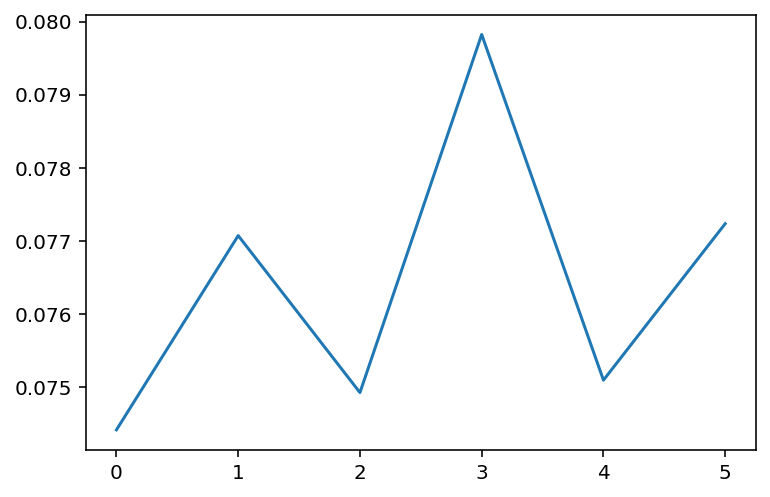

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [19]:
# Loading weights
model.load_weights(WEIGHTS_DIR + "maestro_0.0744.hdf5")

In [20]:
# Predicting and Generating
def generate_notes(num_notes = 200):
  start = np.random.randint(0, len(input) - 1)                             # random starting point

  int_to_note = dict((num, note) for num, note in enumerate(pitchnames))

  pattern = unmod_input[start]                                             # random sequence of num with length of 'sequence_legnth'
                                                                          # unmod means the array has not been reshaped nor normalized
  pred_output = []
                                                         # number of notes to generate
  for note_index in range(num_notes):
      pred_input = np.reshape(pattern, (1, len(pattern), 1))
      pred_input = pred_input / float(n_vocab)

      pred = model.predict(pred_input, verbose=0)

      index = np.argmax(pred)                                              # model.predict returns an array of probabilities, argmax returns the maximum val's index
      result = int_to_note[index]                                          # result is a string representation of a chord or note
      pred_output.append(result)

      pattern.append(index)
      pattern = pattern[1:len(pattern)]                                    # remove first value after adding a new value to pattern



  # Convert numbers predicted by the model back into music21 Note and Chord objects
  # return a list of Not and Chord objects
  offset = 0
  output_notes = []

  for obj in pred_output:
      # obj = chord
      if('.' in obj) or obj.isdigit():
          notes_in_chord = obj.split('.')
          notes = []
          for cur_note in notes_in_chord:
              new_note = note.Note(int(cur_note))
              new_note.storedInstrument = instrument.Piano()
              notes.append(new_note)
          new_chord = chord.Chord(notes)
          new_chord.offset = offset
          output_notes.append(new_chord)
      # obj = note
      else:
          new_note = note.Note(obj)
          new_note.offset = offset
          new_note.storedInstrument = instrument.Piano()
          output_notes.append(new_note)

      offset += 0.5        # distance/duration in between notes and chords

  return output_notes


In [24]:
#@title Generate Music 

numNotes = 200#@param {type:"integer"}

output_notes = generate_notes(numNotes)
midi_stream = stream.Stream(output_notes)

midi_stream.write('midi', fp='test_output.mid')
display_audio('test_output.mid')

Output hidden; open in https://colab.research.google.com to view.